# **Part A**
Count / Frequency based Naive Bayes Classifier

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO Steps Completed:
# 1. Fit method: log priors + log likelihoods (Laplace smoothing)
# 2. Predict method: compute total log probability per class, pick argmax
# 3. Other TODOs to be done in later notebook cells (data loading, vectorizer, etc.)
# =======================================================

def load_pubmed_rct_file(filepath):
    """Reads a .txt file from the PubMed 20k RCT dataset and returns a DataFrame."""
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


class NaiveBayesClassifier:
    """
    Custom Multinomial Naive Bayes Classifier (Scratch Implementation)
    Supports CountVectorizer or TF-IDF style sparse matrices.
    """

    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocab_size = 0

    def fit(self, X_counts, y):
        """Estimate priors and conditional likelihoods from training data."""
        y_arr = np.array(y)
        self.classes = np.unique(y_arr)
        self.vocab_size = X_counts.shape[1]

        total_samples = len(y_arr)

        for cls in self.classes:
            # Extract samples belonging to class 'cls'
            X_cls = X_counts[y_arr == cls]

            # --- Log Prior ---
            # P(cls) = (#docs in class) / (total docs)
            class_prob = X_cls.shape[0] / total_samples
            self.class_priors[cls] = np.log(class_prob + 1e-12)  # avoid log(0)

            # --- Feature Likelihood ---
            # Total word counts per feature in this class
            feature_counts = np.asarray(X_cls.sum(axis=0)).flatten()
            total_words_cls = feature_counts.sum()

            # Apply Laplace smoothing
            smoothed = feature_counts + self.alpha
            denom = total_words_cls + self.alpha * self.vocab_size

            # Store log probabilities of each word given the class
            self.feature_log_probs[cls] = np.log(smoothed / denom)

    def predict(self, X_counts):
        """Predict class labels for the given feature matrix."""
        predictions = []

        for i in range(X_counts.shape[0]):
            x_row = X_counts.getrow(i)
            log_scores = {}

            for cls in self.classes:
                # Start with log prior
                score = self.class_priors[cls]

                # Only consider nonzero features
                indices = x_row.indices
                values = x_row.data

                # Add weighted log likelihoods for observed words
                if len(indices) > 0:
                    score += np.sum(values * self.feature_log_probs[cls][indices])

                log_scores[cls] = score

            # Choose class with highest posterior probability
            predicted_cls = max(log_scores, key=log_scores.get)
            predictions.append(predicted_cls)

        return np.array(predictions)


In [ ]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = '/content' # Changed to look directly in /content
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    # Removed placeholder data creation
    # train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    # test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded to {dir_path}")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [ ]:

#  Feature Extraction and Custom Model Training

if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # Using both unigrams and bigrams gives richer features
        ngram_range=(1, 2),
        # Ignore extremely rare words appearing in <2 docs
        min_df=2
    )

    print("Fitting CountVectorizer on training data...")
    # Fit the vectorizer and convert training text to count matrix
    X_train_counts = count_vectorizer.fit_transform(X_train)

    print(f"Vocabulary successfully created! Total features: {X_train_counts.shape[1]}")

    print("Transforming test data using the same vocabulary...")
    # Convert test text into count matrix using trained vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier (from scratch)
    print("\nTraining the Custom Naive Bayes Classifier (scratch implementation)...")

    # Initialize model with smoothing
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # Fit on training data
    nb_model.fit(X_train_counts, y_train)

    print("Model training completed successfully.")

else:
    print("Skipping training — Training data not available or empty.")


Fitting CountVectorizer on training data...
Vocabulary successfully created! Total features: 301234
Transforming test data using the same vocabulary...

Training the Custom Naive Bayes Classifier (scratch implementation)...
Model training completed successfully.


In [ ]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

try:
    y_test_pred = nb_model.predict(X_test_counts)
except Exception as e:
    print(f"Prediction error: {e}")
    y_test_pred = None

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")







=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7571
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.56      0.57      3621
 CONCLUSIONS       0.63      0.69      0.66      4571
     METHODS       0.81      0.89      0.85      9897
   OBJECTIVE       0.60      0.43      0.50      2333
     RESULTS       0.87      0.80      0.84      9713

    accuracy                           0.76     30135
   macro avg       0.70      0.68      0.68     30135
weighted avg       0.76      0.76      0.75     30135

Macro-averaged F1 score: 0.6825


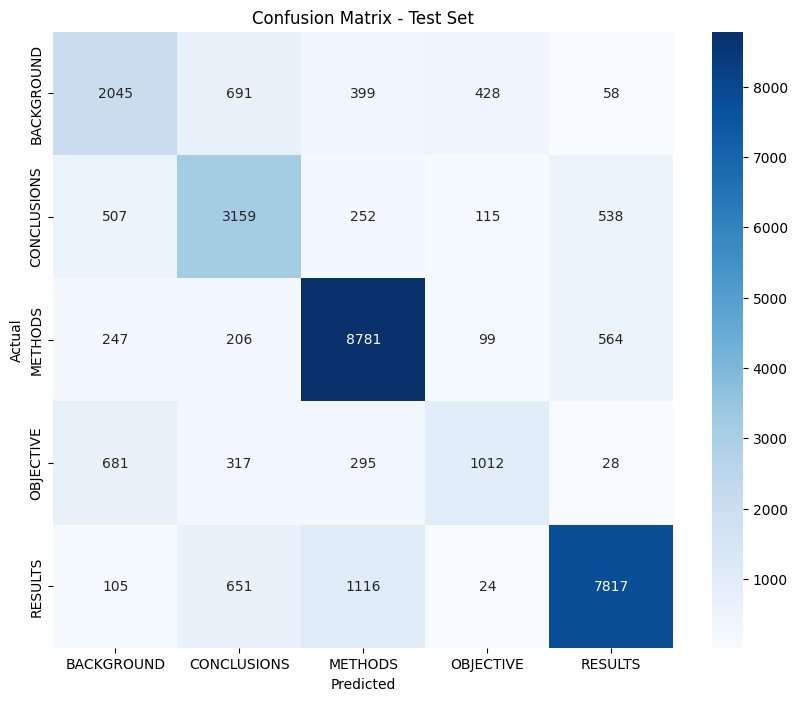

In [ ]:
# Confusion Matrix on test set
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred)

    cm_df = pd.DataFrame(
        cm,
        index=[f"True: {cls}" for cls in target_names],
        columns=[f"Pred: {cls}" for cls in target_names]
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Test Set')
    plt.show()

# **Part B**
TF-IDF score based Classifier

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)
if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
    pass
else:
    print("Initial model evaluation skipped: Predictions not available.")


param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.5, 1.0]
}

if len(X_dev) >= 2:
    grid = GridSearchCV(pipeline, param_grid, cv=2, scoring='f1_macro', n_jobs=-1, verbose=1)

    print("\nStarting Hyperparameter Tuning on Development Set...")
    grid.fit(X_dev, y_dev)
    print("Grid search complete.")
else:
    print("\nInsufficient development data for cross-validation. Skipping grid search.")
    grid = None


if grid is not None and hasattr(grid, 'best_params_'):
    print(f"\nBest parameters: {grid.best_params_}")
    print(f"Best cross-validation score: {grid.best_score_:.4f}")
    pass
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7266
              precision    recall  f1-score   support

  BACKGROUND       0.64      0.43      0.51      3621
 CONCLUSIONS       0.62      0.61      0.62      4571
     METHODS       0.72      0.90      0.80      9897
   OBJECTIVE       0.73      0.10      0.18      2333
     RESULTS       0.80      0.87      0.83      9713

    accuracy                           0.73     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.72      0.73      0.70     30135

Macro-averaged F1 score: 0.5877

Starting Hyperparameter Tuning on Development Set...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Grid search complete.

Best parameters: {'nb__alpha': 0.5, 'tfidf__ngram_range': (1, 1)}
Best cross-validation score: 0.5384


# **Part C**
Bayes Optimal Classifier

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS348
My SRN isPES2UG23CS348
Using dynamic sample size: 10348
Actual sampled training set size used: 10348
Using 10348 samples for training base models.

=== Training Base Models (H1–H5) ===
Training NaiveBayes...
NaiveBayes trained successfully.
Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression trained successfully.
Training RandomForest...
RandomForest trained successfully.
Training DecisionTree...
DecisionTree trained successfully.
Training KNN...
KNN trained successfully.

=== Evaluation of Individual Hypotheses on Test Set ===
NaiveBayes           | Accuracy: 0.6999 | F1 (macro): 0.6203
LogisticRegression   | Accuracy: 0.7089 | F1 (macro): 0.6147
RandomForest         | Accuracy: 0.5213 | F1 (macro): 0.2726
DecisionTree         | Accuracy: 0.4686 | F1 (macro): 0.2444
KNN                  | Accuracy: 0.1656 | F1 (macro): 0.1033

=== Training Voting Classifier (Bayes Optimal Approximation) ===
Voting Classifier trained successfully.

=== Final Evaluation: Bayes Optimal Classifier Approximation ===
Accuracy: 0.6445
              precision    recall  f1-score   support

  BACKGROUND       0.52      0.42      0.46      3621
 CONCLUSIONS       0.64      0.50      0.56      4571
     METHODS       0.57      0.94      0.71      9897
   OBJECTIVE       0.63      

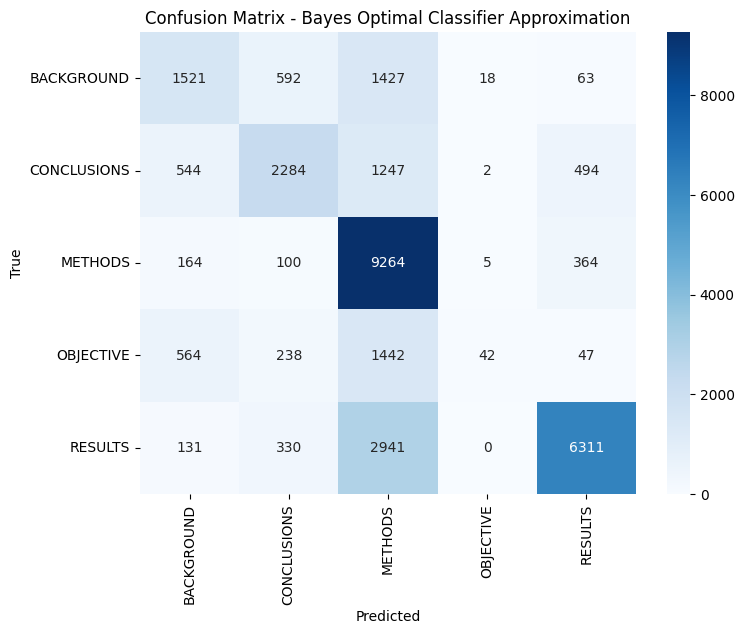

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# =======================================================
# TODO: Implement the following steps:
# 1. Define the five diverse hypothesis pipelines (H1 to H5) using TfidfVectorizer
#    and the specified classifiers (NB, LR, RF, DT, KNN).
# 2. Train each of the five hypotheses on the sampled training data.
# 3. Create a list of estimators for the VotingClassifier.
# 4. Initialize and fit the VotingClassifier (Bayes Optimal Classifier approximation).
# 5. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Sampling for faster training of multiple models (DO NOT CHANGE)
#
# *** STUDENT ACTION REQUIRED ***
# This section dynamically calculates the sample size based on the student's SRN.
# When running this cell, a prompt will appear asking for the full SRN.
#
BASE_SAMPLE_SIZE = 10000

FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        print("My SRN is" + FULL_SRN)
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Assuming X_train and y_train were loaded in Part A
# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one", "sample text two", "sample text three"])
    y_train = pd.Series(["BACKGROUND", "METHODS", "RESULTS"])
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

# Create the sampled training subset
# Ensure SAMPLE_SIZE does not exceed the size of the actual training data
effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

X_train_sampled = X_train[:SAMPLE_SIZE]
y_train_sampled = y_train[:SAMPLE_SIZE]
print(f"Using {len(X_train_sampled)} samples for training base models.")

# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines

# Multinomial Naive Bayes
h1_nb = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', MultinomialNB(alpha=1.0, fit_prior=False))])

# Logistic Regression
h2_lr = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))])

# Random Forest Classifier
h3_rf = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))])

# Decision Tree Classifier
h4_dt = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', DecisionTreeClassifier(max_depth=10, random_state=42))])

# K-Nearest Neighbors
h5_knn = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']


print("\n=== Training Base Models (H1–H5) ===")
for name, model in zip(hypothesis_names, hypotheses):
    print(f"Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)
    print(f"{name} trained successfully.")

print("\n=== Evaluation of Individual Hypotheses on Test Set ===")
for name, model in zip(hypothesis_names, hypotheses):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"{name:20s} | Accuracy: {acc:.4f} | F1 (macro): {f1:.4f}")

estimators = [(name, model) for name, model in zip(hypothesis_names, hypotheses)]

voting_clf = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)
print("\n=== Training Voting Classifier (Bayes Optimal Approximation) ===")
voting_clf.fit(X_train_sampled, y_train_sampled)
print("Voting Classifier trained successfully.")

# Predict and evaluate
print("\n=== Final Evaluation: Bayes Optimal Classifier Approximation ===")
y_pred_voting = voting_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print(classification_report(y_test, y_pred_voting, target_names=target_names))
print(f"Macro F1 Score: {f1_score(y_test, y_pred_voting, average='macro'):.4f}")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_voting, labels=target_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Bayes Optimal Classifier Approximation")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
print("Training individual hypotheses...")
for hyp, name in zip(hypotheses, hypothesis_names):
    print(f"Training {name}...")
    hyp.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")






Training individual hypotheses...
Training NaiveBayes...
Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training RandomForest...
Training DecisionTree...
Training KNN...
All base models trained.


In [ ]:
# List of (name, estimator) tuples for the VotingClassifier
estimators = list(zip(hypothesis_names, hypotheses))

# // TODO: Initialize the VotingClassifier using 'estimators'
boc_hard_voter = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO: Fit the VotingClassifier using the sampled training data
boc_hard_voter.fit(X_train_sampled, y_train_sampled)

# // TODO: Predict y_boc_pred using X_test
y_boc_pred = boc_hard_voter.predict(X_test)



Fitting the VotingClassifier (BOC approximation)...


In [ ]:
print("\n=== Final Evaluation: Bayes Optimal Classifier (Hard Voting) ===")

if y_boc_pred is not None:
    boc_accuracy = accuracy_score(y_test, y_boc_pred)
    boc_f1 = f1_score(y_test, y_boc_pred, average='macro')

    print(f"BOC Accuracy: {boc_accuracy:.4f}")
    print(f"BOC Macro F1 Score: {boc_f1:.4f}")
    print(classification_report(y_test, y_boc_pred, target_names=target_names))
    pass


=== Final Evaluation: Bayes Optimal Classifier (Hard Voting) ===
BOC Accuracy: 0.6445
BOC Macro F1 Score: 0.5024
              precision    recall  f1-score   support

  BACKGROUND       0.52      0.42      0.46      3621
 CONCLUSIONS       0.64      0.50      0.56      4571
     METHODS       0.57      0.94      0.71      9897
   OBJECTIVE       0.63      0.02      0.04      2333
     RESULTS       0.87      0.65      0.74      9713

    accuracy                           0.64     30135
   macro avg       0.65      0.50      0.50     30135
weighted avg       0.67      0.64      0.62     30135



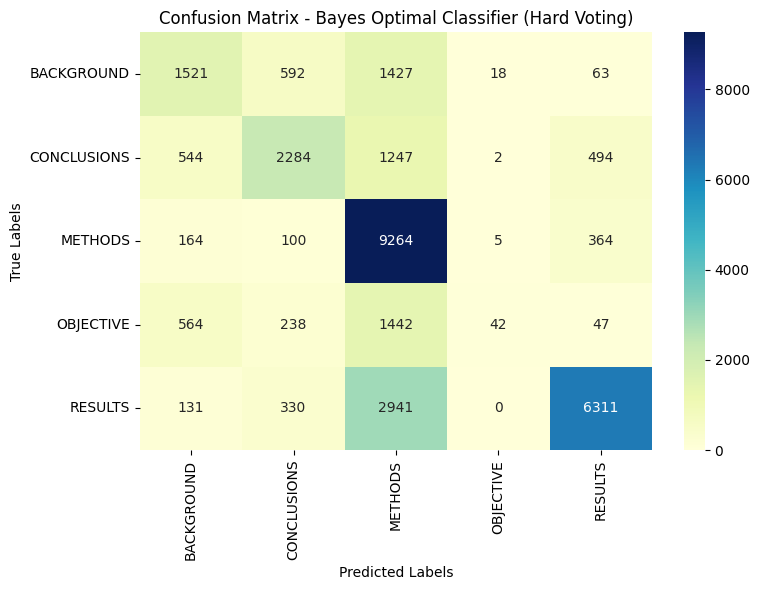

In [ ]:

if y_boc_pred is not None:
    cm = confusion_matrix(y_test, y_boc_pred, labels=target_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix - Bayes Optimal Classifier (Hard Voting)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix cannot be generated — predictions missing.")

Part C Draft

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS348
Using dynamic sample size: 10348
Actual sampled training set size used: 10348

Training all base models...
Training NaiveBayes...
Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training RandomForest...
Training DecisionTree...
Training KNN...
All base models trained.

Calculating posterior weights based on validation likelihood...
Posterior Weights (P(h|D)):
NaiveBayes           -> 0.341
LogisticRegression   -> 0.327
RandomForest         -> 0.120
DecisionTree         -> 0.116
KNN                  -> 0.096

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7101
Macro F1 Score: 0.6098

Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.46      0.55      0.51      3621
 CONCLUSIONS       0.64      0.51      0.57      4571
     METHODS       0.73      0.88      0.80      9897
   OBJECTIVE       0.70      0.25      0.37      2333
     RESULTS       0.83      0.80      0.81      9713

    accuracy                           0.71     30135
   macro avg       0.67      0.60      0.61     30135
weig

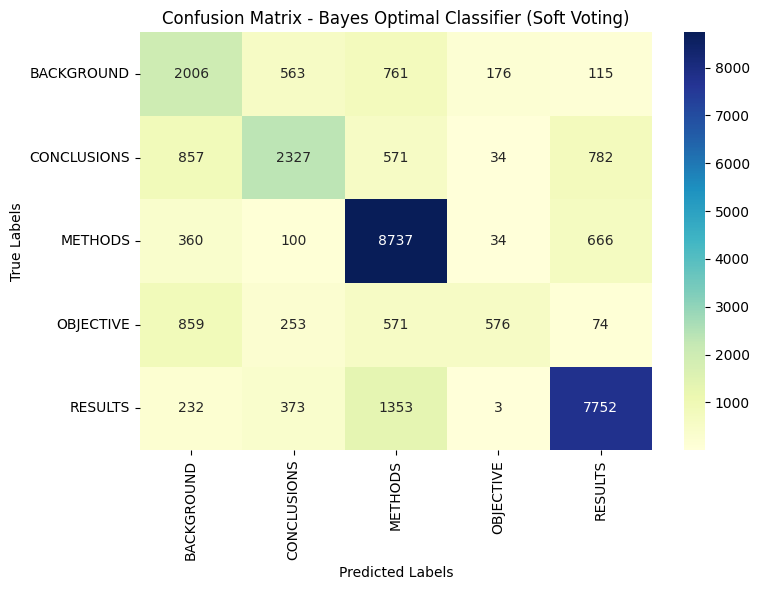

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # Import train_test_split


BASE_SAMPLE_SIZE = 10000

FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("WARNING: SRN input failed or format is incorrect. Using default sample size.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")


effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")


# // TODO: Train all five hypotheses on X_train_sampled and y_train_sampled using a for loop.
print("\nTraining all base models...")
for name, model in zip(hypothesis_names, hypotheses):
    print(f"Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")


# // TODO: Implement the Posterior Weight Calculation (P(h_i | D)).
# This requires splitting X_train_sampled into a small train_sub/val_sub set
# and calculating the validation log-likelihood for each model. Normalize these to get posterior_weights.

print("\nCalculating posterior weights based on validation likelihood...")

# Split into small validation subset
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42
)

log_likelihoods = []

for name, model in zip(hypothesis_names, hypotheses):
    y_val_pred = model.predict(X_val_sub)
    # Using F1-macro as a proxy for model evidence likelihood
    f1 = f1_score(y_val_sub, y_val_pred, average='macro')
    log_likelihoods.append(np.log(f1 + 1e-6))  # small offset to avoid log(0)

# Normalize to posterior weights
exp_vals = np.exp(log_likelihoods - np.max(log_likelihoods))
posterior_weights = exp_vals / np.sum(exp_vals)

print("Posterior Weights (P(h|D)):")
for name, w in zip(hypothesis_names, posterior_weights):
    print(f"{name:20s} -> {w:.3f}")


# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO: Fit the VotingClassifier using the full sampled training data (X_train_sampled, y_train_sampled)
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")


# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# // TODO: Predict y_pred using X_test, and then calculate and visualize evaluation metrics.
y_pred = boc_soft_voter.predict(X_test)


# Final Evaluation (STUDENT TASK)
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    # Example calculations:
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # // TODO: Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
    cm = confusion_matrix(y_test, y_pred, labels=target_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix - Bayes Optimal Classifier (Soft Voting)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
else:
    print("Evaluation skipped: Predictions not generated.")